In [16]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [17]:
# read in dataset Jill
dset = pd.read_csv('MichelleMobilia2.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

16001
26.668333333333333


In [18]:
#Variables
f=10

# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 12.85 minutes
Autonomic light: 10.1 minutes
Normal breathing: 1.58333333333 minutes
Cardio: 1.18666666667 minutes
 Total: 25.72 minutes


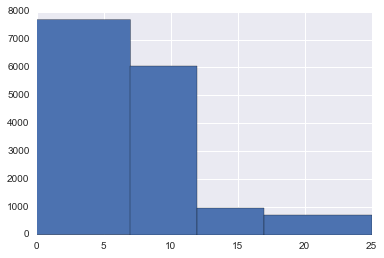

In [19]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/600
b2=n[1]/600
b3=n[2]/600
b4=n[3]/600

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print(" Total: " + str(b1+b2+b3+b4) + " minutes")

In [20]:
f = d

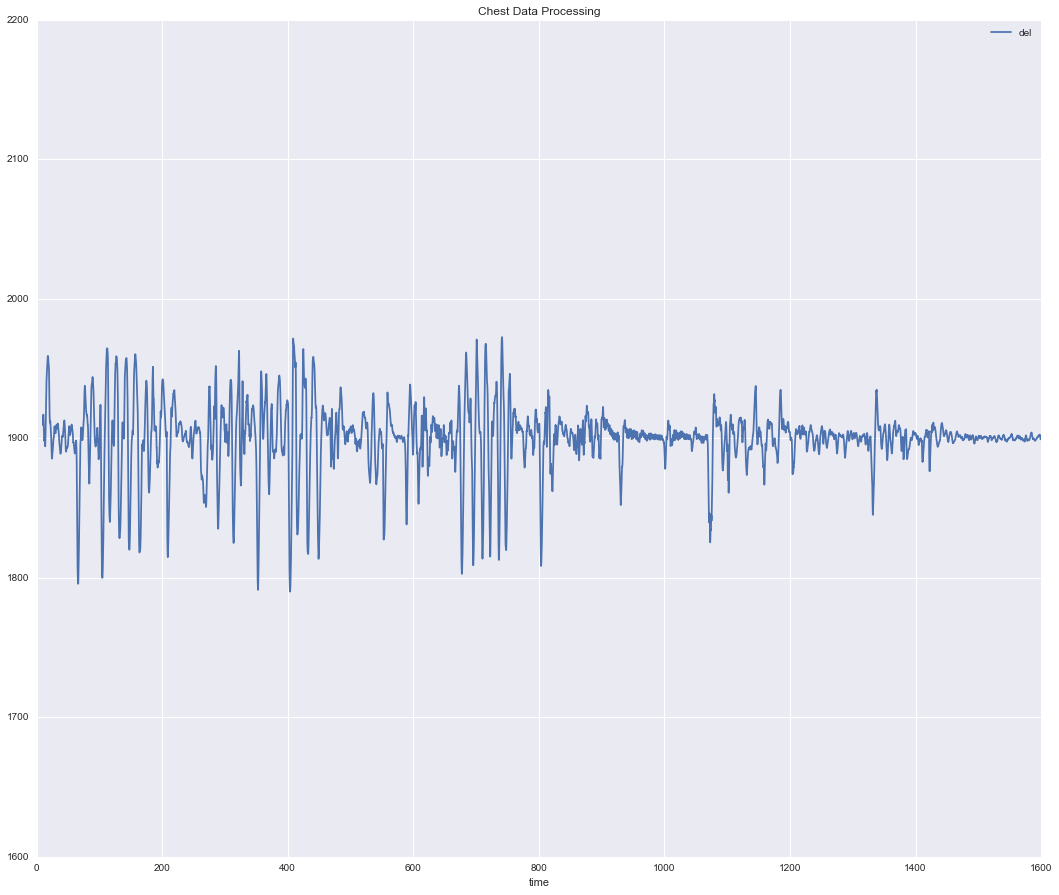

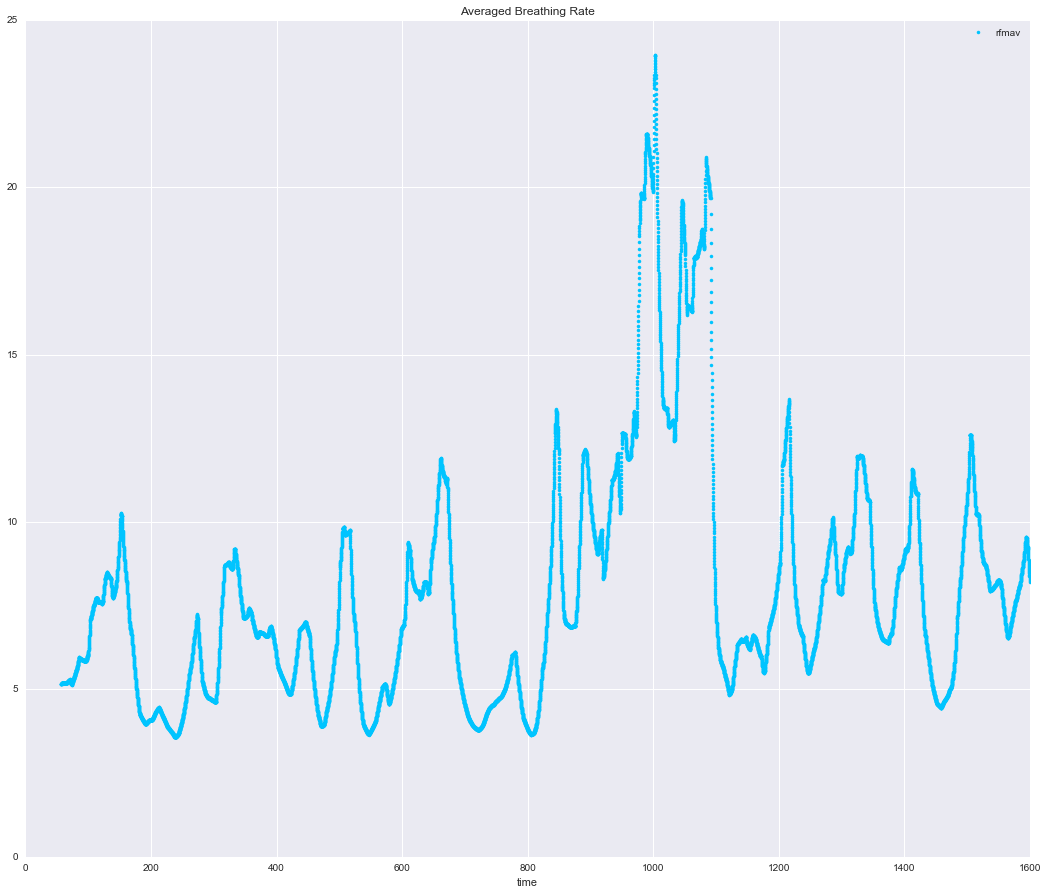

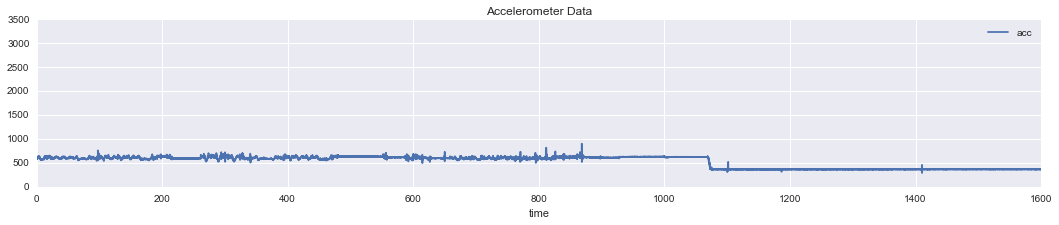

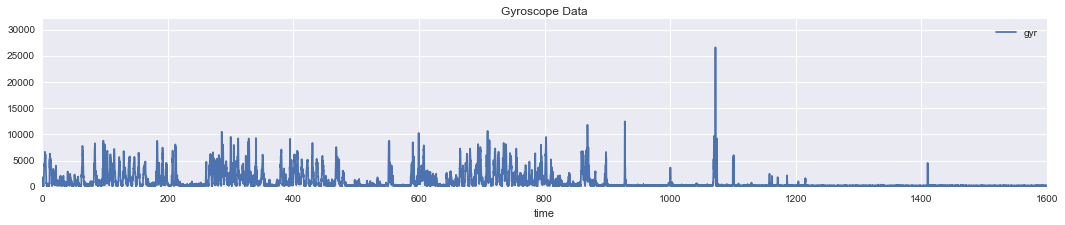

In [21]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,3500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [22]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   2210   2144  -76 -346  488  -746   242  -197     0.0  ...    
1000    1000   2246   2196  -80 -232  604  -301  1524  -420   100.0  ...    
2000    2000   2206   1944  -17  -16  632  -227   423   101   200.0  ...    
3000    3000   2105   1950   47  259  497  6687 -1510   925   300.0  ...    
4000    4000   2263   2139 -101 -265  567  1186     3  -765   400.0  ...    
5000    5000   2214   2059  -41  -68  627   133   156    28   500.0  ...    
6000    6000   2169   2089  -24 -252  574 -2171   584 -1827   600.0  ...    
7000    7000   2170   2176 -372 -109  448  -603   212  -130   700.0  ...    
8000    8000   2208   2194  -97 -381  438   405  -492   171   800.0  ...    
9000    9000   2160   2103  134  508  312    28  -133   -59   900.0  ...    
10000  10000   2174   2105  103  457  408   487   478 -1195  1000.0  ...    
11000  11000   2102   1937   76  -52 -354   189  2850  4267  1100.0  ...    

In [23]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2210,2144,-76,-346,488,-746,242,-197,0.0,...,[nan],NaN,NaN,NaN,NaN,NaN,603.022388,808.634033,1900,1600
1,1,2218,2141,-82,-346,480,-1033,357,-398,0.1,...,[nan],NaN,NaN,NaN,NaN,NaN,597.360862,1163.160350,1900,1600
2,2,2221,2144,-72,-368,486,-1065,255,62,0.2,...,[nan],NaN,NaN,NaN,NaN,NaN,613.843628,1096.856417,1900,1600
3,3,2227,2141,-95,-360,489,-436,457,-21,0.3,...,[nan],NaN,NaN,NaN,NaN,NaN,614.610446,631.969936,1900,1600
4,4,2211,2153,-82,-362,479,270,421,-329,0.4,...,[nan],NaN,NaN,NaN,NaN,NaN,605.977722,598.650148,1900,1600
5,5,2216,2143,-74,-381,499,162,-198,506,0.5,...,[nan],NaN,NaN,NaN,NaN,NaN,632.169281,566.995591,1900,1600
6,6,2211,2135,-73,-375,472,787,735,340,0.6,...,[nan],NaN,NaN,NaN,NaN,NaN,607.238009,1129.244880,1900,1600
7,7,2212,2120,-84,-335,470,1631,757,297,0.7,...,[nan],NaN,NaN,NaN,NaN,NaN,583.250375,1822.476063,1900,1600
8,8,2211,2099,-113,-349,473,237,1090,203,0.8,...,[nan],NaN,NaN,NaN,NaN,NaN,598.580822,1133.789222,1900,1600
9,9,2220,2086,-89,-335,463,-285,318,-31,0.9,...,[nan],NaN,NaN,NaN,NaN,NaN,578.372717,428.147171,1900,1600
